In [316]:
import numpy as np
import PIL
import cv2
from cv2 import matchTemplate as cv2m
import time
from numba import jit
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [317]:

score_board = np.zeros((15,15))
board = np.zeros((15,15))
neighbours = np.zeros((15,15))
cneighbour = np.array([[-1,-1],[-1,0],[-1,1],[0,-1],[0,1],[1,-1],[1,0],[1,1]])
star = np.array([
                [-2,-2],
                [-3,-3],
                [-4,-4],
                [2,2],
                [3,3],
                [4,4],
                [-2,2],
                [-3,3],
                [-4,4],
                [2,-2],
                [3,-3],
                [4,-4],
                [0,2],
                [0,3],
                [0,4],
                [2,0],
                [3,0],
                [4,0],
                [0,-2],
                [0,-3],
                [0,-4],
                [-2,0],
                [-3,0],
                [-4,0]])
# cneighbour = np.array([[-1,1,0,-1,1,0,-1,1],[-1,-1,-1,0,0,1,1,1]])
seq = np.array([1,1,1,1,1])
diag = np.array([[1,0,0,0,0],
                [0,1,0,0,0],
                [0,0,1,0,0],
                [0,0,0,1,0],
                [0,0,0,0,1]])
otherdiag = np.array([  [0,0,0,0,1],
                        [0,0,0,1,0],
                        [0,0,1,0,0],
                        [0,1,0,0,0],
                        [1,0,0,0,0]])
eye = np.array([[0,1,0],[1,1,1],[0,1,0]])
cross = np.array([[1,0,1],[0,1,0],[1,0,1]])
block = np.array([[1,1,1],[1,1,1],[1,1,1]])
eye3 = np.array([[0,0,0,0,0],
                [0,0,1,0,0],
                [0,1,1,1,0],
                [0,0,1,0,0],
                [0,0,0,0,0]])
eye3_mask = np.array([[0,0,1,0,0],
                        [0,0,1,0,0],
                        [1,1,1,1,1],
                        [0,0,1,0,0],
                        [0,0,1,0,0]])
cross3 = np.array([[0,0,0,0,0],
                    [0,1,0,1,0],
                    [0,0,1,0,0],
                    [0,1,0,1,0],
                    [0,0,0,0,0]])
cross3_mask = np.array([[1,0,0,0,1],
                    [0,1,0,1,0],
                    [0,0,1,0,0],
                    [0,1,0,1,0],
                    [1,0,0,0,1]])
line = np.array([0,1,1,1,0])
line4 = np.array([0,1,1,1,1,0])
line4_diag = np.array([[0,0,0,0,0,0],
                        [0,1,0,0,0,0],
                        [0,0,1,0,0,0],
                        [0,0,0,1,0,0],
                        [0,0,0,0,1,0],
                        [0,0,0,0,0,0]])
line4_otherdiag = np.array([[0,0,0,0,0,0],
                        [0,0,0,0,1,0],
                        [0,0,0,1,0,0],
                        [0,0,1,0,0,0],
                        [0,1,0,0,0,0],
                        [0,0,0,0,0,0]])
line4_diag_mask = np.array([[1,0,0,0,0,0],
                        [0,1,0,0,0,0],
                        [0,0,1,0,0,0],
                        [0,0,0,1,0,0],
                        [0,0,0,0,1,0],
                        [0,0,0,0,0,1]])
line4_otherdiag_mask = np.array([[0,0,0,0,0,1],
                        [0,0,0,0,1,0],
                        [0,0,0,1,0,0],
                        [0,0,1,0,0,0],
                        [0,1,0,0,0,0],
                        [1,0,0,0,0,0]])
line_diag = np.array([[0,0,0,0,0],
                    [0,1,0,0,0],
                    [0,0,1,0,0],
                    [0,0,0,1,0],
                    [0,0,0,0,0]])
line_otherdiag = np.array([  [0,0,0,0,0],
                        [0,0,0,1,0],
                        [0,0,1,0,0],
                        [0,1,0,0,0],
                        [0,0,0,0,0]])

In [318]:
def make_image(board):
    w, h = 512, 512
    s = 512//15
    img = np.zeros((h, w, 3), dtype=np.uint8)
    for i in range(15):
        for j in range(15):
            if board[i,j] == 0:
                img[i*s:(i+1)*s, j*s:(j+1)*s, 0] = 255
                img[i*s:(i+1)*s, j*s:(j+1)*s, 1] = 255
                img[i*s:(i+1)*s, j*s:(j+1)*s, 2] = 255
            elif board[i,j] == 1:
                img[i*s:(i+1)*s, j*s:(j+1)*s, 0] = 0
                img[i*s:(i+1)*s, j*s:(j+1)*s, 1] = 0
                img[i*s:(i+1)*s, j*s:(j+1)*s, 2] = 255
            elif board[i,j] == -1:
                img[i*s:(i+1)*s, j*s:(j+1)*s, 0] = 255
                img[i*s:(i+1)*s, j*s:(j+1)*s, 1] = 0
                img[i*s:(i+1)*s, j*s:(j+1)*s, 2] = 0
    return img




In [319]:
# @jit
def find_sequence(arr, seq,mask_=None):
    arr_=arr+2
    seq_=seq+2
    S = cv2m(arr_.astype('uint8'),seq_.astype('uint8'),method=cv2.TM_SQDIFF,mask=mask_)
    idx = np.where(S == 0)[0]
    return idx.shape[0]

# @jit
def get_winner(board):
    # check the row
    if find_sequence(board, seq)>0:
        return 1
    # check the column
    if find_sequence(board.T, seq)>0:
        return 1
    # check the diagonal
    if find_sequence(board, diag, diag.astype('uint8'))>0:
        return 1
    # check the diagonal
    if find_sequence(board, otherdiag, otherdiag.astype('uint8'))>0:
        return 1
    ## now do the same for teh other player
    if find_sequence(board, seq*-1)>0:
        return -1
    if find_sequence(board.T, seq*-1)>0:
        return -1
    if find_sequence(board, diag*-1,diag.astype('uint8'))>0:
        return -1
    if find_sequence(board, otherdiag*-1,otherdiag.astype('uint8'))>0:
        return -1
    return 0

# @jit
def convolution_score(board,player):
    val= 0
    p=5
    board_ = board.copy()
    board_[board_ == player] = p
    board_[board_==-player] = 255
    val+= np.sum(cv2m(board_.astype('uint8'),  p*seq.astype('uint8'),method=cv2.TM_SQDIFF)**4)
    val+= np.sum(cv2m(board_.T.astype('uint8'),p*seq.astype('uint8'),method=cv2.TM_SQDIFF)**4)
    val+= np.sum(cv2m(board_.astype('uint8'),  p*diag.astype('uint8'),method=cv2.TM_SQDIFF, mask=diag.astype('uint8'))**4)
    val+= np.sum(cv2m(board_.astype('uint8'),  p*otherdiag.astype('uint8'),method=cv2.TM_SQDIFF, mask=otherdiag.astype('uint8'))**4)
    val+= np.sum(cv2m(board_.astype('uint8'),  p*eye3.astype('uint8'),method=cv2.TM_SQDIFF, mask=eye3_mask.astype('uint8')))
    val+= np.sum(cv2m(board_.astype('uint8'),  p*cross3.astype('uint8'),method=cv2.TM_SQDIFF, mask=cross3.astype('uint8')))
    # val+=np.sum(cv2m(board_.astype('uint8'),   p*line.astype('uint8'),method=cv2.TM_SQDIFF, mask=seq.astype('uint8')))
    # val+=np.sum(cv2m(board_.T.astype('uint8'), p*line.astype('uint8'),method=cv2.TM_SQDIFF, mask=seq.astype('uint8')))
    # val+=np.sum(cv2m(board_.astype('uint8'),   p*line_diag.astype('uint8'),method=cv2.TM_SQDIFF, mask=diag.astype('uint8')))
    # val+=np.sum(cv2m(board_.astype('uint8'),   p*line_otherdiag.astype('uint8'),method=cv2.TM_SQDIFF, mask=otherdiag.astype('uint8')))
    return (val**2)  # caus lower is better and we want highr

In [320]:
# @jit
def get_score_move(board,n):
    possible = score_board.copy()
    possible[board != 0] = 0
    maxamount = min(n,len(np.where(possible>0)[0]))
    if maxamount == 0:
        return -1
    ind = np.unravel_index(np.argsort(possible, axis=None)[::-1][:maxamount], possible.shape)
    return ind

# @jit
def get_moves(board, neighbours,n):
    #get coordinates of the neighbour cell with the highest score but not in the board
    neighbours_ = neighbours.copy()
    neighbours_[board!=0] = 0
    # print("the fi")
    # for i in range(15):
    #     for j in range(15):
    #         if neighbours_[i,j] == 0:
    #             print('-', end='')
    #         else:
    #             print((int)(neighbours_[i,j]), end='')
    #     print('')
    # print('')
    maxamount = min(n,len(np.where(neighbours_>0)[0]))
    ind = np.unravel_index(np.argsort(neighbours_, axis=None)[::-1][:maxamount], neighbours_.shape)
    # print(ind)
    # print("m",maxamount)
    # print(neighbours_[ind])
    return ind

In [334]:

# @jit
def alpha_beta_prunning(board, neighbours,player, alpha, beta, depth, idx):
    if depth == 0 :
        # return evaluate_board(board, player)-evaluate_board(board, -player)
        return min(convolution_score(board,player) / convolution_score(board,-player),9999999998)
    # if depth == 3:
    #     score =  evaluate_board(board, -player) / convolution_score(board,player)
    #     if start_score>score: # if current position is wors than start position
    #         print("early cut off")
    #         return score
    # winner = get_winner(board)
    # if winner != 0:
    #     return -winner*player*depth*9999999999 + (convolution_score(board,-player) / convolution_score(board,player))
    V = -99999999
    # moves = get_immediate(board,idx)
    # temp = (get_moves(board, neighbours,20))
    # moves = (np.append(moves[0], temp[0]), np.append(moves[1], temp[1]))
    # idx = explore_convolve(board,player,10)
    # iss = np.random.randint(0,idx[0].shape[0],nmoves)
    moves = get_moves(board, neighbours,50)
    # check if any move is terminal
    for i in range(len(moves[0])):
        move = (moves[0][i],moves[1][i])
        board[move] = player
        win = get_winner(board)
        board[move] = 0
        if win != 0:
            return win*player*depth*depth*9999999999 + (convolution_score(board,-player) / convolution_score(board,player))
    for i in range(len(moves[0])):
        moven = np.array([moves[0][i],moves[1][i]])
        moven = moven[:, None]
        move = (moves[0][i],moves[1][i])
        board[move] = player
        t = np.tile(cneighbour.T, moven.shape[1]).T + np.repeat(moven.T, 8, axis=0)
        # t = t[np.where(t < 15) and np.where(t >= 0)]
        _t = (t[:, 0] >= 0) * (t[:, 0] < 15) * (t[:, 1] >= 0) * (t[:, 1] < 15)
        # t = np.array((t[::2],t[1::2]))
        t = t[_t]
        t = (t[:,0], t[:,1])
        neighbours[t] += 1
        V = max(V,alpha_beta_prunning(board, neighbours, -player, -beta, -alpha, depth-1, t))
        board[move] = 0
        neighbours[t] -= 1
        if V>=beta:
            return V
        alpha = max(alpha,V)
    return alpha

In [322]:

def solve(board,neighbours,player, last_x, last_y):
    # get remaining depth
    # player = -player

    remaining = 120 - len(np.where(board != 0)[0])
    depth = min(remaining,4)
    # get neighbours
    # get the indexes of the empty cells
    # idx = np.where(board != 0 )
    # get the neighbours of the empty cells
    # t = np.tile(cneighbour.T, idx[0].shape[0]).T + np.repeat(np.array(idx).T, 8, axis=0)
    # # t = t[np.where(t < 15 ) and np.where(t > 0)]
    # # t = np.tile(cneighbour.T, move.shape[1]).T + np.repeat(move.T, 8, axis=0)
    # _t = (t[:, 0] >= 0) * (t[:, 0] < 15) * (t[:, 1] >= 0) * (t[:, 1] < 15)
    # # t = np.array((t[::2],t[1::2]))
    # t = t[_t]
    # t = (t[:,0], t[:,1])
    # neighbours[t] += 1
    # start_score = convolution_score(board,-player)/convolution_score(board,player)
    #display the neighbours
    # print("neighbours")
    # print(neighbours)
    print("board")
    draw(board)
    # parameters
    best_x=-1
    best_y=-1
    alpha = -np.Inf
    beta = np.Inf
    V= alpha
    moves = get_moves(board, neighbours,15*15)
    # check if any move is terminal
    for i in range(len(moves[0])):
        move = (moves[0][i],moves[1][i])
        board[move] = player
        if get_winner(board) != 0:
            return (move[0],move[1])
        board[move] = 0
    for i in range(len(moves[0])):
        move = (moves[0][i],moves[1][i])
        board[move] = -player
        if get_winner(board) != 0:
            return (move[0],move[1])
        board[move] = 0
    # better moves
    if len(np.where(score_board!=0)[0])>0:
        moves = get_score_move(board,10)
        temp = (get_moves(board, neighbours,30))
        # if len(temp[0])>50:
        #     temp = (get_moves(board, neighbours,50))
        moves = (np.append(moves[0], temp[0]), np.append(moves[1], temp[1]))
        temp = set()
        for i in range(len(moves[0])):
            temp.add((moves[0][i],moves[1][i]))
        moves = (np.array([i[0] for i in temp]),np.array( [i[1] for i in temp]))

    # moves = get_immediate(board,(np.array([last_x]),np.array([last_y])))
    # temp = (get_moves(board, neighbours,15*15))
    # moves = (np.append(moves[0], temp[0]), np.append(moves[1], temp[1]))
    # moves = get_first_layer(board,neighbours)
    
    
    print("number of moves:", len(moves[0]), player)
    for i in range(len(moves[0])):
        moven = np.array([moves[0][i],moves[1][i]])
        moven = moven[:, None]
        move = (moves[0][i],moves[1][i])
        # play
        # print(player)
        # print(f"before move: {move}")
        # draw(board)
        board[move] = player
        # print(f"after move: {move}")
        # draw(board)
        t = np.tile(cneighbour.T, moven.shape[1]).T + np.repeat(moven.T, 8, axis=0)
        _t = (t[:, 0] >= 0) * (t[:, 0] < 15) * (t[:, 1] >= 0) * (t[:, 1] < 15)
        # t = np.array((t[::2],t[1::2]))
        t = t[_t]
        t = (t[:,0], t[:,1])
        neighbours[t] += 1
        #evaluate
        V = max(V, alpha_beta_prunning(board,neighbours,-player,-beta,-alpha,depth-1, t))
        score_board[move]+=V
        print(i,"move: ", move, "score: ", V)
        #unplay
        board[move] = 0
        neighbours[t] -= 1
        if V >= beta:
            best_x = move[0]
            best_y = move[1]
            break
        if V > alpha:
            alpha = V
            best_x = move[0]
            best_y = move[1]
    
    print("best move: ", best_x, best_y)
    return (best_x, best_y)

In [323]:
def display():
    # pyplot 1 * 3
    plt.subplot(1,3,1)
    plt.imshow(make_image(board))
    plt.title("board")
    # plt.axis('off')
    # display the score board
    plt.subplot(1,3,2)
    plt.imshow(score_board)
    plt.title("score board")
    plt.axis('off')
    # display the neighbours
    plt.subplot(1,3,3)
    plt.imshow(neighbours, cmap='gray')
    plt.title("neighbours")
    plt.axis('off')
    plt.show()

def draw(board):
    # print the columns and the rows
    print("   ", end="")
    for i in range(15):
        print(f" {str(i).ljust(2)}", end="")
    print("")
    for i in range(15):
        print(f"{str(i).ljust(2)} ", end="")
        for j in range(15):
            if board[i,j] == 0:
                print('---', end='')
            elif board[i,j] == 1:
                print(" X ", end='')
            else:
                print(" O ", end='')
        print('')
    print('')

# SETUP

In [324]:
# main loop
player = 1
turn = 0
board = np.zeros((15,15))
neighbours = np.zeros((15,15))
score_board = np.zeros((15,15))

# MAINLOOP

## PLAYER MOVE

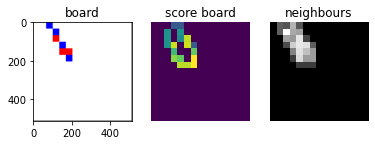

player:  -1
board: 


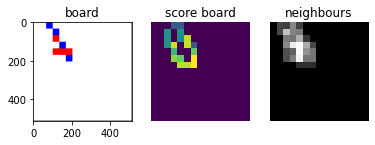

    0  1  2  3  4  5  6  7  8  9  10 11 12 13 14
0  ------ X ------------------------------------
1  --------- X ---------------------------------
2  --------- O ---------------------------------
3  ------------ X ------------------------------
4  --------- O  O  O ---------------------------
5  --------------- X ---------------------------
6  ---------------------------------------------
7  ---------------------------------------------
8  ---------------------------------------------
9  ---------------------------------------------
10 ---------------------------------------------
11 ---------------------------------------------
12 ---------------------------------------------
13 ---------------------------------------------
14 ---------------------------------------------

player:  1
evaluations
player 1: 0.024675791399521748
player -1: 40.52554926442527


In [332]:

turn+=1
#display the board

# get user input
display()
print("player: ", player)
print("board: ")
x = int(input("x: "))
y = int(input("y: "))
# play
board[(x,y)] = player
# get neighbours
move = np.array([x,y])
move = move[:, None]
t = np.tile(cneighbour.T, move.shape[1]).T + np.repeat(move.T, 8, axis=0)
_t = (t[:, 0] >= 0) * (t[:, 0] < 15) * (t[:, 1] >= 0) * (t[:, 1] < 15)
# t = np.array((t[::2],t[1::2]))
t = t[_t]
t = (t[:,0], t[:,1])
neighbours[t] += 2
player = -player
display()
draw(board)
print("player: ", player)
print("evaluations")
print("player 1:",convolution_score(board,-1) / convolution_score(board,1))
print("player -1:",convolution_score(board,1) / convolution_score(board,-1))
if get_winner(board) != 0:
    print("winner: ", get_winner(board))


## AI MOVE

board
    0  1  2  3  4  5  6  7  8  9  10 11 12 13 14
0  ------ X ------------------------------------
1  --------- X ---------------------------------
2  --------- O ---------------------------------
3  ------------ X ------------------------------
4  ------ O  O  O  O  O  X ---------------------
5  ------------ X  X ---------------------------
6  ---------------------------------------------
7  ---------------------------------------------
8  ---------------------------------------------
9  ---------------------------------------------
10 ---------------------------------------------
11 ---------------------------------------------
12 ---------------------------------------------
13 ---------------------------------------------
14 ---------------------------------------------

AI move:  (3, 3)
time:  0.0020673274993896484 (s)


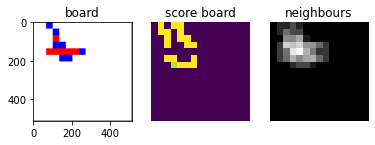

    0  1  2  3  4  5  6  7  8  9  10 11 12 13 14
0  ------ X ------------------------------------
1  --------- X ---------------------------------
2  --------- O ---------------------------------
3  --------- X  X ------------------------------
4  ------ O  O  O  O  O  X ---------------------
5  ------------ X  X ---------------------------
6  ---------------------------------------------
7  ---------------------------------------------
8  ---------------------------------------------
9  ---------------------------------------------
10 ---------------------------------------------
11 ---------------------------------------------
12 ---------------------------------------------
13 ---------------------------------------------
14 ---------------------------------------------

time:  0.0020673274993896484 (s)
player:  -1
evaluations
player X: 18.45784266239957
player O: 0.05417751241520211
winner:  -1


In [338]:
turn+=1
#AI play
# print("AI play")
start = time.time()
move = solve(board,neighbours,player,0,0)
end = time.time()
print("AI move: ", move)
print("time: ", end-start,"(s)")
# play
board[move] = player
# get neighbours
move = np.array([move[0],move[1]])
move = move[:, None]
t = np.tile(cneighbour.T, move.shape[1]).T + np.repeat(move.T, 8, axis=0)
_t = (t[:, 0] >= 0) * (t[:, 0] < 15) * (t[:, 1] >= 0) * (t[:, 1] < 15)
# t = np.array((t[::2],t[1::2]))
t = t[_t]
t = (t[:,0], t[:,1])
neighbours[t] += 2
neighbours*=0.90
score_board*=0.5
score_board[board!=0]=0
player*=-1
display()
draw(board)
print("time: ", end-start,"(s)")
print("player: ", player)
print("evaluations")
print("player X:",convolution_score(board,1) / convolution_score(board,-1))
print("player O:",convolution_score(board,-1) / convolution_score(board,1))
if get_winner(board) != 0:
    print("winner: ", get_winner(board))
